## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 

#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import torchvision
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [2]:
x = torch.randn(5, 6)
y = torch.randn(6, 3)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`:

In [3]:
z = torch.zeros(5,3)
x @ y

tensor([[ 1.0827,  2.1807, -0.7690],
        [-6.0848, -1.4528,  1.9415],
        [-1.0707, -5.2442,  6.8236],
        [ 0.2964,  4.8306,  4.5893],
        [-2.3965,  0.4962, -2.8341]])

In [4]:
# your code here 
z.add(x @ y)

tensor([[ 1.0827,  2.1807, -0.7690],
        [-6.0848, -1.4528,  1.9415],
        [-1.0707, -5.2442,  6.8236],
        [ 0.2964,  4.8306,  4.5893],
        [-2.3965,  0.4962, -2.8341]])

**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [5]:
def relu_forward(x):
    return x * (x > 0) + torch.zeros_like(x)

assert torch.all(F.relu(x) == relu_forward(x))

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [6]:
def elu_forward(x, alpha):
    return x * (x > 0) + torch.min(torch.zeros_like(x),alpha*(torch.exp(x) - 1))

assert torch.all(F.elu(x) == elu_forward(x, 1.0))

Тут я не понимаю почему он не всегда проходит assertation, потому что ответы до четырех знаков после запятой одинаковые:

In [7]:
F.elu(x)

tensor([[ 0.2287,  1.0128,  0.0413, -0.8365,  1.6963,  2.3377],
        [-0.4833,  0.9557, -0.7361,  1.6396, -0.7763, -0.8726],
        [-0.6583,  3.0981,  1.3187,  0.8038,  1.8432,  0.6526],
        [ 1.5910, -0.1520,  0.2492, -0.7012, -0.7078, -0.8525],
        [-0.1045, -0.7134, -0.5997, -0.6096,  0.6414, -0.6844]])

In [8]:
elu_forward(x, 1)

tensor([[ 0.2287,  1.0128,  0.0413, -0.8365,  1.6963,  2.3377],
        [-0.4833,  0.9557, -0.7361,  1.6396, -0.7763, -0.8726],
        [-0.6583,  3.0981,  1.3187,  0.8038,  1.8432,  0.6526],
        [ 1.5910, -0.1520,  0.2492, -0.7012, -0.7078, -0.8525],
        [-0.1045, -0.7134, -0.5997, -0.6096,  0.6414, -0.6844]])

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [9]:
def lrelu_forward(x, alpha):
    return x * (x > 0) + torch.min(torch.zeros_like(x),alpha * x)

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [10]:
def mish(x):
    return x * torch.tanh(torch.log(1 + torch.exp(x)))

In [11]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [12]:
def swish(x):
    return x * torch.sigmoid(x)

In [13]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к линейной регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg {T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1 {t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2 {t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [14]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [15]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        super().__init__(params, defaults)

    def _group_step(self, group):
        # One group contains information about values passed in init
        # and model parameters to update
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
                
        for param in filter(lambda x: x.grad is not None, group['params']):
            self._init_adam_buffer(param)
            
            param_state = self.state[param]
            g = param.grad
            
            m, v, t = self._get_adam_buffer(param)
                       
            param_state['m'] = beta_1 * m + (1 - beta_1) * g
            
            param_state['v'] = beta_2 * v + (1 - beta_2) * (g ** 2)
            
            m_hat = m / (1 - beta_1 ** t)
            v_hat = v / (1 - beta_2 ** t)
            
            param -= (lr * m_hat) / torch.sqrt(v_hat + eps)
            param_state['t'] += 1
                        

    def _get_adam_buffer(self, param):
        """
        Get accumulated gradients for Adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for Adagrad.

        Returns
        -------
        Accumulated Adam gradients for parameter.
        """
        
        param_state = self.state[param]
        return param_state['m'], param_state['v'], param_state['t']
        
        pass

    def _init_adam_buffer(self, param):
        """
        Initialize accumulated gradeints for adam.

        Parameters
        ----------
        param : `torch.Tensor`, required
            Model parameter to get accumulated gradeints for adam.
        """
        param_state = self.state[param]
        
        if 't' not in param_state:
            param_state['t'] = 1        
        if 'm' not in param_state:
            param_state['m'] = torch.zeros_like(param)
        if 'v' not in param_state:
            param_state['v'] = torch.zeros_like(param)  
    

Проверим работу градиента:

In [16]:
from sklearn.datasets import make_regression

def seed_everything(seed: int):
    # Зафиксировать seed.
    # Это понадобится, чтобы убедиться
    # в правильности работы нашего Optimizer
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


# make_regression возвращает 2 переменные: данные и таргет для них
# так как они возвращаётся как np.array,
# вызовем для каждого из них команду torch.from_numpy
X, y = map(
    lambda x: torch.from_numpy(x).float(),
    make_regression(n_samples=200, n_features=2)
)

def get_model():
    # Таким образом, мы при каждом вызове будем получить
    # модель с одной и той же инициализацией весов
    seed_everything(13)
    return torch.nn.Sequential(
        torch.nn.Linear(2, 10),
        torch.nn.Linear(10, 1)
    )

def check_optimizer(model, optim, num_iter):
    loss = torch.nn.MSELoss()
    for i in range(num_iter):
        output = loss(model(X), y.unsqueeze(-1))
        output.backward()
        optim.step()
        optim.zero_grad()
        if i % 100 == 0:
            print(f'Iteration {i} loss:', output.item())

In [17]:
model = get_model()
optim = Adam(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 4060.505859375
Iteration 100 loss: 3995.941650390625
Iteration 200 loss: 3897.8720703125
Iteration 300 loss: 3738.679931640625
Iteration 400 loss: 3513.75634765625
Iteration 500 loss: 3233.68896484375
Iteration 600 loss: 2916.566162109375
Iteration 700 loss: 2580.857421875
Iteration 800 loss: 2242.891845703125
Iteration 900 loss: 1916.1507568359375


In [18]:
model = get_model()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
check_optimizer(model, optim, num_iter=1000)

Iteration 0 loss: 4060.505859375
Iteration 100 loss: 3995.242431640625
Iteration 200 loss: 3896.7509765625
Iteration 300 loss: 3736.746337890625
Iteration 400 loss: 3511.5400390625
Iteration 500 loss: 3231.650390625
Iteration 600 loss: 2915.04443359375
Iteration 700 loss: 2579.994140625
Iteration 800 loss: 2242.687744140625
Iteration 900 loss: 1916.5224609375


**Task**: Создайте параметры для обучения линейной регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [19]:
var = - math.sqrt(6) / math.sqrt(28 ** 2 + 10) #т.к. размер изображения 28*28 = n_in, n_out = 10 классов

weights = torch.tensor(np.random.uniform(-var , var, size =(10, 28 ** 2)),requires_grad = True)
intercept = torch.tensor(np.random.uniform(-var , var, size =(1, 10)), requires_grad = True)

In [20]:
optimizer = Adam([weights, intercept])
criterion = nn.CrossEntropyLoss()

Загрузим данные и создадим даталоадеры:

In [21]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
train_dataloader = DataLoader(fashion_mnist_train, batch_size = 16, shuffle=True, num_workers=2)# your code here

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

eval_dataloader = DataLoader(fashion_mnist_eval, batch_size = 16, num_workers=2)# your code here

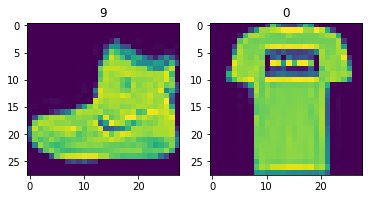

In [22]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(fashion_mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(fashion_mnist_train[i][1]))
plt.show()

Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
class LogReg(torch.nn.Module):
    def __init__(self):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(784, 10)

    def forward(self, x):
        x = x.reshape(-1, 784)
        out = torch.sigmoid(self.linear(x))
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)               
        return out, criterion(out, labels), accuracy(out,labels)
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                      
        return {'val_loss': criterion(out, labels), 'val_acc': accuracy(out, labels)}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = LogReg()

def weight_init(md):
    if isinstance(md, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(md.weight)
        if m.bias: 
            torch.nn.init.xavier_uniform_(md.bias)
            
weight_init(model)

In [27]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in eval_dataloader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_dataloader, eval_dataloader, opt_func=optimizer):
    train_loss =0
    train_acc=0
    train_size = 0

    history = []
    all_acc=[]
    all_losses = []
    all_train_losses=[]
    all_train_acc=[]

    optimizer = Adam(model.parameters())

    for epoch in range(epochs):
        # Training Phase 
        for batch in train_dataloader:
            optimizer.zero_grad()
            out, loss, acc = model.training_step(batch)
            all_train_acc.append(acc.item())
            all_train_losses.append(loss.item())
            loss.backward()
            optimizer.step()

        result = evaluate(model, eval_dataloader)
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history, all_train_losses, all_train_acc

In [28]:
history, history_loss, history_acc = fit(20, model, train_dataloader, eval_dataloader)

Epoch [0], val_loss: 1.6258, val_acc: 0.7850
Epoch [1], val_loss: 1.6074, val_acc: 0.7971
Epoch [2], val_loss: 1.6004, val_acc: 0.8182
Epoch [3], val_loss: 1.5946, val_acc: 0.8224
Epoch [4], val_loss: 1.5923, val_acc: 0.8250
Epoch [5], val_loss: 1.5900, val_acc: 0.8269
Epoch [6], val_loss: 1.5896, val_acc: 0.8270
Epoch [7], val_loss: 1.5884, val_acc: 0.8287
Epoch [8], val_loss: 1.5865, val_acc: 0.8303
Epoch [9], val_loss: 1.5864, val_acc: 0.8333
Epoch [10], val_loss: 1.5853, val_acc: 0.8295
Epoch [11], val_loss: 1.5838, val_acc: 0.8331
Epoch [12], val_loss: 1.5833, val_acc: 0.8354
Epoch [13], val_loss: 1.5840, val_acc: 0.8320
Epoch [14], val_loss: 1.5849, val_acc: 0.8332
Epoch [15], val_loss: 1.5821, val_acc: 0.8326
Epoch [16], val_loss: 1.5838, val_acc: 0.8300
Epoch [17], val_loss: 1.5810, val_acc: 0.8341
Epoch [18], val_loss: 1.5820, val_acc: 0.8325
Epoch [19], val_loss: 1.5813, val_acc: 0.8348


In [29]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('iterations')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

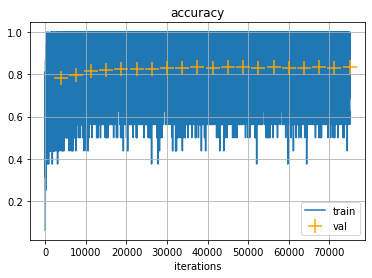

In [30]:
accuracies = [result['val_acc'] for result in history]

plot_history(history_acc, accuracies, "accuracy")

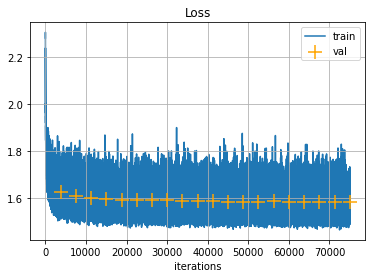

In [31]:
loss = [result['val_loss'] for result in history]

plot_history(history_loss, loss, "Loss")

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

Т.к. при расчете $\hat m, \hat v$ используется $1-\beta_i^t$, при достаточно большом t знаменатель дроби стремится к 1, а значит $m^hat, v^hat$ стремятся к m, v. При этом на нулевом шаге при $m_0 = 0: \hat m_t = \dfrac{m_t}{1-\beta^t}$, то есть смещенный initial guess не учитывается в модели.

мы видим, что вариация как loss, так и accuracy достаточно быстро возрастает, а значит модель переобучается по сути за первую тысячу итераций.

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [32]:
NUM_EPOCH = 20

In [33]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):
    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []
    
    for epoch in range(NUM_EPOCH):
        model.train()
        train_loss = 0.
        train_size = 0
        train_acc = 0.
        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.to(device)
            labels = labels.to(device)

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))

            _, pred_classes = torch.max(y_pred, 1)
            train_acc += (pred_classes == labels).sum().item()
            train_acc_log.append(np.mean((pred_classes == labels).cpu().numpy()))

            optimizer.step()

        val_loss = 0.
        val_size = 0
        val_acc = 0.
        model.eval()
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                val_loss += loss.item()
                val_size += pred.size(0)

                _, pred_classes = torch.max(pred, 1)
                val_acc += (pred_classes == labels).sum().item()
        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_acc / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        plot_history(train_acc_log, val_acc_log, 'accuracy')

        print('Train loss:', train_loss / train_size)
        print('Train acc:', train_acc / train_size)
        print('Val loss:', val_loss / val_size)
        print('Val acc:', val_acc / val_size)

In [34]:
criterion = nn.CrossEntropyLoss().to(device)

In [35]:
model_fullconnect = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
).to(device)

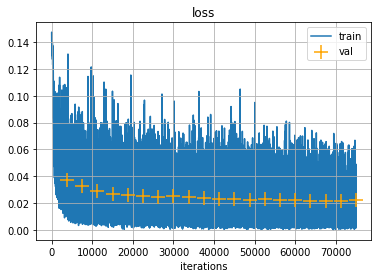

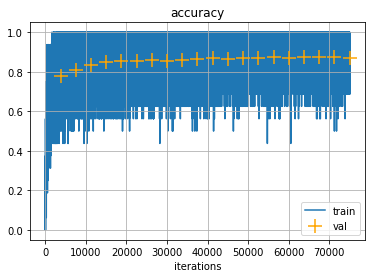

Train loss: 0.017258884287703162
Train acc: 0.8990333333333334
Val loss: 0.022108856454119086
Val acc: 0.869


In [36]:
optimizerS = torch.optim.SGD(model_fullconnect.parameters(), lr=0.001, momentum=0.9)

train(model_fullconnect, criterion, optimizerS, train_dataloader, eval_dataloader)

In [37]:
model_vggstyle = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(32 * 7 * 7, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax()
).to(device)

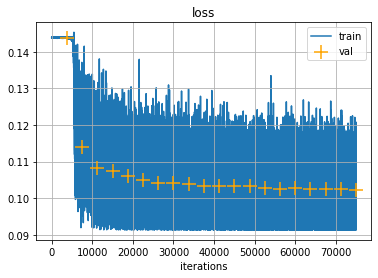

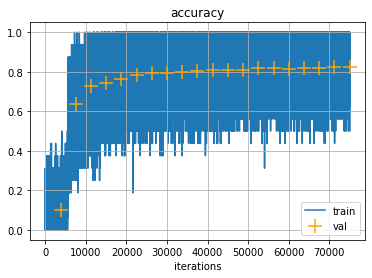

Train loss: 0.10220154322385788
Train acc: 0.82615
Val loss: 0.10232752318382263
Val acc: 0.8244


In [38]:
optimizerS = torch.optim.SGD(model_vggstyle.parameters(), lr=0.001, momentum=0.9)

train(model_vggstyle, criterion, optimizerS, train_dataloader, eval_dataloader)

In [39]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

model_resnetstyle = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, 3, padding=1),
    
    ResNet(
        torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
        )
    ),

    ResNet(
        torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
        )
    ),
    
    torch.nn.AdaptiveAvgPool2d(1),
    
    nn.Flatten(),
    torch.nn.Linear(32, 10)
).to(device)

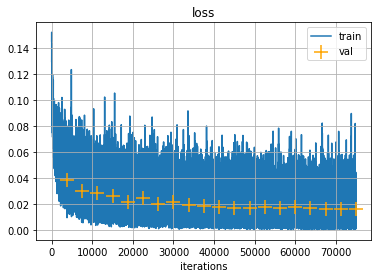

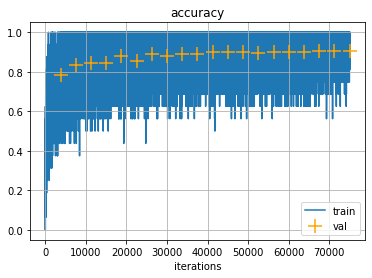

Train loss: 0.014692734462022782
Train acc: 0.9181333333333334
Val loss: 0.016434814727399497
Val acc: 0.9076


In [40]:
optimizerS = torch.optim.SGD(model_resnetstyle.parameters(), lr=0.001, momentum=0.9)

train(model_resnetstyle, criterion, optimizerS, train_dataloader, eval_dataloader)

In [41]:
# train and visualize and write summary down there

### Проверим сети с другим оптимайзером

In [42]:
model_fullconnect = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
).to(device)

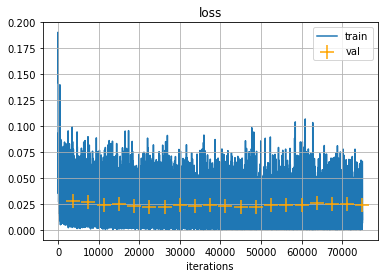

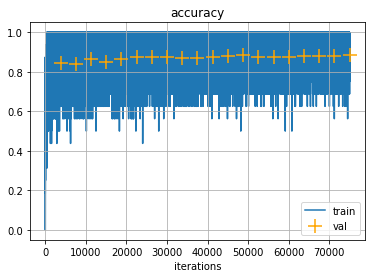

Train loss: 0.014540363002358937
Train acc: 0.9144
Val loss: 0.02435493169664405
Val acc: 0.8833


In [43]:
optimizerR = torch.optim.RMSprop(model_fullconnect.parameters(), lr=0.001)

train(model_fullconnect, criterion, optimizerR, train_dataloader, eval_dataloader)

In [44]:
model_vggstyle = nn.Sequential(
    nn.Conv2d(1, 16, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.2),

    nn.Flatten(),
    nn.Linear(32 * 7 * 7, 128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.Softmax()
).to(device)

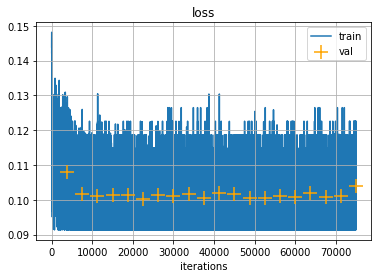

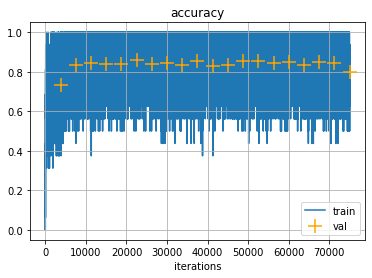

Train loss: 0.10182318004568418
Train acc: 0.83195
Val loss: 0.10383828939199448
Val acc: 0.7997


In [45]:
optimizerR = torch.optim.RMSprop(model_vggstyle.parameters(), lr=0.001)

train(model_vggstyle, criterion, optimizerR, train_dataloader, eval_dataloader)

In [46]:
class ResNet(torch.nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, inputs):
        return self.module(inputs) + inputs

model_resnetstyle = torch.nn.Sequential(
    torch.nn.Conv2d(1, 32, 3, padding=1),
    # 32 filters in and out, no max pooling so the shapes can be added
    ResNet(
        torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
        )
    ),
    # Another ResNet block, you could make more of them
    # Downsampling using maxpool and others could be done in between etc. etc.
    ResNet(
        torch.nn.Sequential(
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
        )
    ),
    # Pool all the 32 filters to 1, you may need to use `torch.squeeze after this layer`
    torch.nn.AdaptiveAvgPool2d(1),
    # 32 10 classes
    nn.Flatten(),
    torch.nn.Linear(32, 10)
).to(device)

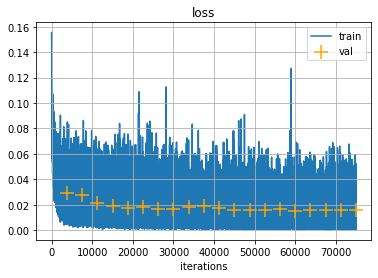

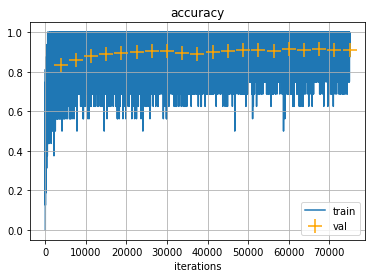

Train loss: 0.01214182978705503
Train acc: 0.9299833333333334
Val loss: 0.015972501626145094
Val acc: 0.9126


In [47]:
optimizerR = torch.optim.RMSprop(model_resnetstyle.parameters(), lr=0.001)

train(model_resnetstyle, criterion, optimizerR, train_dataloader, eval_dataloader)

Можно сделать несколько выводов о перформансе моделей: в среднем, RMSprop оказлася более подходящим оптимайзером, чем SGD с показателем momentum = 0.9: это может быть связано с тем, что Rms prop меньше обновляет веса, которые достаточно часто менялись до этого, но вместо полной суммы обновлений используется средний квадрат градиента с учетом всех итераций. Стоит отметить хорошие показатели качества полносвязаной модели с тремя линейными слоями: она достаточно быстро сходилась и давала хорошее качество при сравнительно небольшом количестве итераций, но начала переобучаться при использовании RMS при большом количестве итерацией. Хорошие результаты качества показала ResNet-style модель, худшие показатели дала VGG модель.
